# Missing Imputation
This notebook applies three methods to impute missing values across three datasets. 
- Mean/Mode 
- KNN
- Random Forest

Imputation process is applied within each dataset. Though there might be interactions among variables from different modalities, joinining the table and then conducting imputation will cause a significant sample loss. Note that this notebook is not solving the missing problem due to multi-modalities. We will discuss sample loss missing (patients who haven't took lumbar puncture or MRI) in future analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
import seaborn as sns
import os, sys
from tqdm import tqdm

### Load Pre-processed data

In [2]:
uds = pd.read_csv("../data/data_cleaned/uds.csv")
mri = pd.read_csv("../data/data_cleaned/mri.csv")
csf = pd.read_csv("../data/data_cleaned/csf.csv")
uds_dict = pd.read_csv("../data/data_dictionary/uds_feature_dictionary_cleaned.csv")
mri_dict = pd.read_csv("../data/data_dictionary/mri_feature_dictionary_cleaned.csv") 
print(uds.shape, mri.shape, csf.shape)

(45100, 96) (2873, 173) (2180, 7)


### Preliminary Feature Dropping (with high missing rate)
- Column missing rates have to be less than 85% (can be tuned later)
- UDS, MRI, CSF keep all patients

In [3]:
def drop_missing(df, row_thres=0.5, col_thres=0.5):
    df = df.loc[df.isna().mean(axis=1)<row_thres, df.isna().mean(axis=0)<col_thres]
    return df

# print([(r, (uds.isna().mean()<r).sum()) for r in np.arange(0, 1, 0.05)])
print("Original UDS shape:  ", uds.shape)
print("UDS: features need to have missing rate below 85%")
uds = drop_missing(uds, row_thres=1, col_thres=0.8)
print("UDS: After dropping features:  ", uds.shape)
print("UDS: Num of Features needs to be imputed:  ", (uds.isna().sum()>0).sum())

print("\nMRI features need to have missing rate below 85%")
mri = drop_missing(mri, row_thres=1, col_thres=0.85)
print("MRI: After dropping features:  ", mri.shape)
print("MRI: Num of Features needs to be imputed:  ", (mri.isna().sum()>0).sum())

print("\nCSF features need to have missing rate below 85%")
csf = drop_missing(csf, row_thres=1, col_thres=0.85)
print("CSF: After dropping features:  ", csf.shape)
print("CSF: Num of Features needs to be imputed:  ", (csf.isna().sum()>0).sum())

Original UDS shape:   (45100, 96)
UDS: features need to have missing rate below 85%
UDS: After dropping features:   (45100, 89)
UDS: Num of Features needs to be imputed:   73

MRI features need to have missing rate below 85%
MRI: After dropping features:   (2873, 161)
MRI: Num of Features needs to be imputed:   6

CSF features need to have missing rate below 85%
CSF: After dropping features:   (2180, 7)
CSF: Num of Features needs to be imputed:   4


In [4]:
uds_drop_columns = ['NACCID', 'NACCADC', 'NACCVNUM', 'datetime', 'SEX', 'NACCAGE','EDUC', 
                    'NACCUDSD', 'NACCALZP', 'NACCAD3', 'NACCAD5']
mri_drop_columns = ['NACCID', 'NACCVNUM', 'datetime', 'datetime_UDS', 'timediff', 'within-a-year']
csf_drop_columns = ['NACCID', 'CSFABMD', 'CSFTTMD', 'CSFPTMD']

uds_to_fill = uds.drop(uds_drop_columns, axis=1).copy()
mri_to_fill = mri.drop(mri_drop_columns, axis=1).copy()
csf_to_fill = csf.drop(csf_drop_columns, axis=1).copy()    

## Method 1: Mean/Mode Imputation
- Unique values less than 10 took as categorical variables, impute missing with mode
- Numeric variables will be imputed using mean. Outliers will be excluded using 1st and 99th quantile

In [5]:
def impute_missing(df):
    for c in df.columns:
        try:
            if df[c].nunique() <= 10:
                df[c] = df[c].fillna(value = df[c].mode().values[-1])
            else:
                lb, ub = df[c].quantile(0.01), df[c].quantile(0.99)
                df[c] = df[c].fillna(value = df[(df[c]>lb) & (df[c] < ub)][c].mean())
        except Exception as e:
            print("Message:  ", e)
            print("Cannot convert column ", c)
    return df

uds_mm_imputed = impute_missing(uds_to_fill.copy())
mri_mm_imputed = impute_missing(mri_to_fill.copy())
csf_mm_imputed = impute_missing(csf_to_fill.copy())

uds_mm = pd.concat([uds[uds_drop_columns], uds_mm_imputed], axis=1)
mri_mm = pd.concat([mri[mri_drop_columns], mri_mm_imputed], axis=1)
csf_mm = pd.concat([csf[csf_drop_columns], csf_mm_imputed], axis=1)

uds_mm.to_csv("../data/data_imputed/Mean-Mode/uds.csv", index = False)
mri_mm.to_csv("../data/data_imputed/Mean-Mode/mri.csv", index = False)
csf_mm.to_csv("../data/data_imputed/Mean-Mode/csf.csv", index = False)
print("Saving Mean/Mode Imputation Successful...")

Saving Mean/Mode Imputation Successful...


## Method 2: KNN Imputation
- Impute the missing by taking the average from K nearest neighbors. Be careful, this method will cause some problems on categorical variables.

In [6]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

In [7]:
imputer.fit(uds_to_fill.iloc[:15000,])
uds_KNN_imputed = imputer.transform(uds_to_fill)
mri_KNN_imputed = imputer.fit_transform(mri_to_fill)
csf_KNN_imputed = imputer.fit_transform(csf_to_fill)

uds_KNN = pd.concat([uds[uds_drop_columns], pd.DataFrame(uds_KNN_imputed, columns = uds_to_fill.columns)], axis=1)
mri_KNN = pd.concat([mri[mri_drop_columns], pd.DataFrame(mri_KNN_imputed, columns = mri_to_fill.columns)], axis=1)
csf_KNN = pd.concat([csf[csf_drop_columns], pd.DataFrame(csf_KNN_imputed, columns = csf_to_fill.columns)], axis=1)

uds_KNN.to_csv("../data/data_imputed/KNN/uds.csv", index = False)
mri_KNN.to_csv("../data/data_imputed/KNN/mri.csv", index = False)
csf_KNN.to_csv("../data/data_imputed/KNN/csf.csv", index = False)
print("Saving KNN Imputation Successful...")

Saving KNN Imputation Successful...


## Method 3: Random Forest Feature Imputation

Utilizes Random forest to impute missing values for all features. The procedure is described as follows
- record missing locations
- Initialize all missing values using mean and mode
- Iterating features Y from the least to the most missing rates, use the rest of the features X to predict Y on the observed values (i.e. $Y[idx_{Yobs}] \sim X[idx_{Yobs},]$), then predict $Y[idx_{Ymis}]$ using $X[idx_{Ymis},]$

In [8]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [9]:
def clip_df(df, col_limit_dict=None):
    if col_limit_dict is not None:
        for i, c in enumerate(col_limit_dict.keys()):
            df.loc[:,c] = np.clip(df.loc[:,c], col_limit_dict[c][0], col_limit_dict[c][1])
    return df

def missing_rf(df_temp, column_fill_order, nas_idx_map, cat_var, num_var, n_estimators=100, max_depth=None):
    mse, rf_metrics = {}, {}
    for c in column_fill_order:
        rest_columns = list(set(df_temp.columns) - set([c]))
        X, X_predict = df_temp.loc[~df_temp.index.isin(nas_idx_map[c]), rest_columns], df_temp.loc[nas_idx_map[c], rest_columns]
        y = df_temp.loc[~df_temp.index.isin(nas_idx_map[c]), c]

        # Fit Random Forest Model
        rf_class = RandomForestRegressor if c in num_var else RandomForestClassifier
        rf = rf_class(max_depth=max_depth, n_estimators=n_estimators, random_state=48, n_jobs=5)  
        rf.fit(X, y)
        df_temp.loc[nas_idx_map[c], c] = rf.predict(X_predict)
        rf_metrics[c] = mean_squared_error(y, rf.predict(X)) if c in num_var else accuracy_score(y, rf.predict(X)) * 100
    mse = {c: rf_metrics[c] for c in column_fill_order if c in num_var}
    acc = {c: rf_metrics[c] for c in column_fill_order if c in cat_var} 
    largest_mse = sorted(mse.items(), key=lambda x: x[1], reverse=True)[0] 
    if len(acc) == 0:
        print("Mean MSE: {:.3f} (Largest-{}: {:.3f})".format(np.mean(list(mse.values())), largest_mse[0], largest_mse[1]))
    else:
        smallest_acc = sorted(acc.items(), key=lambda x: x[1])[0] 
        print("Mean MSE: {:.3f} (Largest-{}: {:.3f})\t Mean ACC: {:.3f} (Smallest-{}: {:.3f}) ".format(
            np.mean(list(mse.values())), largest_mse[0], largest_mse[1], 
            np.mean(list(acc.values())), smallest_acc[0], smallest_acc[1]))
    return df_temp

def impute_missing_RF(df, n_estimators=50, max_depth=None, stop=5, small=1e-3, column_limit_dict=None):
    df_temp = df.copy()
    df_temp = clip_df(df_temp, column_limit_dict)
    label_encoder = {}
    # First filling the most least missing columns
    nas = df_temp.isna()
    column_fill_order = list(nas.sum()[nas.sum()>0].sort_values().to_dict().keys())
    nas_idx_map = {c: nas[nas[c]==True].index for c in nas.columns}

    # Prepare the initial mean/mode filled df_temp
    cat_var = df.nunique()[df.nunique().values <= 10].index.values
    for c in cat_var:
        df_temp[c] = df_temp[c].fillna(value = df_temp[c].mode().values[-1])
        encoder = LabelEncoder()
        df_temp[c] = encoder.fit_transform(df_temp[c])
        label_encoder[c] = encoder
    num_var = np.array(list(set(df.columns) - set(cat_var)))
    for c in num_var:
        lb, ub = df_temp[c].quantile(0.01), df_temp[c].quantile(0.99)
        df_temp[c] = df_temp[c].fillna(value = df_temp[c].mean())
    
    # Start imputing missing using RF
    iteration=0
    imputed_values = {c: np.array([0 for i in range(v)]) for c, v in nas.sum()[nas.sum()>0].sort_values().to_dict().items()}
    new_imputed_values = {c: df_temp.loc[nas_idx_map[c], c].values for c in column_fill_order}
    error = [np.mean((imputed_values[c] - new_imputed_values[c])**2) for c in imputed_values]
    while max(error) > small and iteration < stop:
        print("Iteration {}: {:.3f} (on {})".format(iteration, max(error), list(nas_idx_map.keys())[np.argmax(error)]))
        imputed_values = new_imputed_values
        df_temp = missing_rf(df_temp, column_fill_order, nas_idx_map, cat_var, num_var, n_estimators, max_depth)
        new_imputed_values = {c: df_temp.loc[nas_idx_map[c], c].values for c in column_fill_order}
        error = [np.mean((imputed_values[c] - new_imputed_values[c])**2) for c in imputed_values]
        iteration += 1
    print("Finished-Iteration {}: {:.3f} (on {})".format(iteration, max(error), column_fill_order[np.argmax(error)]))
    if iteration == stop:
        print("Warning: Does not converge")
    for c in cat_var:
        df_temp[c] = label_encoder[c].inverse_transform(df_temp[c])
    df_temp = clip_df(df_temp, column_limit_dict)
    return df_temp

In [10]:
uds_col_limit_dict = {c: [uds_to_fill.loc[uds_to_fill[c] > uds_to_fill[c].quantile(0.01), c].min(), 
                          uds_to_fill.loc[uds_to_fill[c] < uds_to_fill[c].quantile(0.99), c].max()] for c in uds_to_fill.columns 
                      if uds_to_fill[c].nunique() > 10}
mri_col_limit_dict = {c: [mri_to_fill.loc[mri_to_fill[c] > mri_to_fill[c].quantile(0.01), c].min(), 
                          mri_to_fill.loc[mri_to_fill[c] < mri_to_fill[c].quantile(0.99), c].max()] for c in mri_to_fill.columns 
                      if mri_to_fill[c].nunique() > 10}
csf_col_limit_dict = {c: [csf_to_fill.loc[csf_to_fill[c] > csf_to_fill[c].quantile(0.01), c].min(), 
                          csf_to_fill.loc[csf_to_fill[c] < csf_to_fill[c].quantile(0.99), c].max()] for c in csf_to_fill.columns 
                      if csf_to_fill[c].nunique() > 10}

uds_rf_imputed = impute_missing_RF(uds_to_fill.copy(), stop=5, column_limit_dict = uds_col_limit_dict)
mri_rf_imputed = impute_missing_RF(mri_to_fill.copy(), stop=5, column_limit_dict=mri_col_limit_dict)
csf_rf_imputed = impute_missing_RF(csf_to_fill.copy(), stop=5, column_limit_dict=csf_col_limit_dict)

uds_rf = pd.concat([uds[uds_drop_columns], uds_rf_imputed], axis=1)
mri_rf = pd.concat([mri[mri_drop_columns], mri_rf_imputed], axis=1)
csf_rf = pd.concat([csf[csf_drop_columns], csf_rf_imputed], axis=1)

uds_rf.to_csv("../data/data_imputed/RF/uds.csv", index = False)
mri_rf.to_csv("../data/data_imputed/RF/mri.csv", index = False)
csf_rf.to_csv("../data/data_imputed/RF/csf.csv", index = False)

print("Saving RF Imputation Successful...")

Iteration 0: 17482.222 (on IRR)
Mean MSE: 13.802 (Largest-TRAILB: 226.826)	 Mean ACC: 99.969 (Smallest-APP: 99.920) 
Iteration 1: 18344.582 (on IRR)
Mean MSE: 7.078 (Largest-TRAILB: 111.203)	 Mean ACC: 99.975 (Smallest-APP: 99.934) 
Iteration 2: 1232.356 (on IRR)
Mean MSE: 7.368 (Largest-TRAILB: 115.486)	 Mean ACC: 99.974 (Smallest-APP: 99.930) 
Iteration 3: 353.800 (on IRR)
Mean MSE: 7.439 (Largest-TRAILB: 117.093)	 Mean ACC: 99.974 (Smallest-APP: 99.927) 
Iteration 4: 294.765 (on IRR)
Mean MSE: 7.442 (Largest-TRAILB: 117.614)	 Mean ACC: 99.974 (Smallest-APP: 99.944) 
Finished-Iteration 5: 235.371 (on TRAILB)
Iteration 0: 1896881.901 (on CSFVOL)
Mean MSE: 10.947 (Largest-NACCICV: 47.370)
Iteration 1: 19311.960 (on CSFVOL)
Mean MSE: 10.947 (Largest-NACCICV: 47.370)
Iteration 2: 28.435 (on GRAYVOL)
Mean MSE: 10.948 (Largest-NACCICV: 47.370)
Iteration 3: 0.430 (on GRAYVOL)
Mean MSE: 10.947 (Largest-NACCICV: 47.370)
Iteration 4: 0.043 (on GRAYVOL)
Mean MSE: 10.947 (Largest-NACCICV: 47.370

# Examine Imputation Results

In [16]:
def examine_missing_imputation(df, df_imputed, num, nrow, ncol, figsize, bins=100, suptitle=None):
    var = df.isna().sum()[df.isna().sum()>0].sort_values().index.values[-num:][::-1]
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    for i, v in enumerate(var):
        ax = axes[i] if nrow == 1 or ncol == 1 else axes[i//ncol, i%ncol]
        ax.hist(df[v], bins=100, alpha=0.5, label='Original')
        ax.hist(df_imputed.loc[df[v].isna(), v], bins=bins, alpha=0.5, label='Imputed')
        ax.legend()
        ax.set_title("{} (missing-{:.3f}%)".format(v, df[v].isna().sum()/df.shape[0]*100), fontsize = 16)
    plt.tight_layout()
    if suptitle is not None:
        plt.suptitle(suptitle, y=1.03, fontsize = 25)
    plt.show()

# UDS

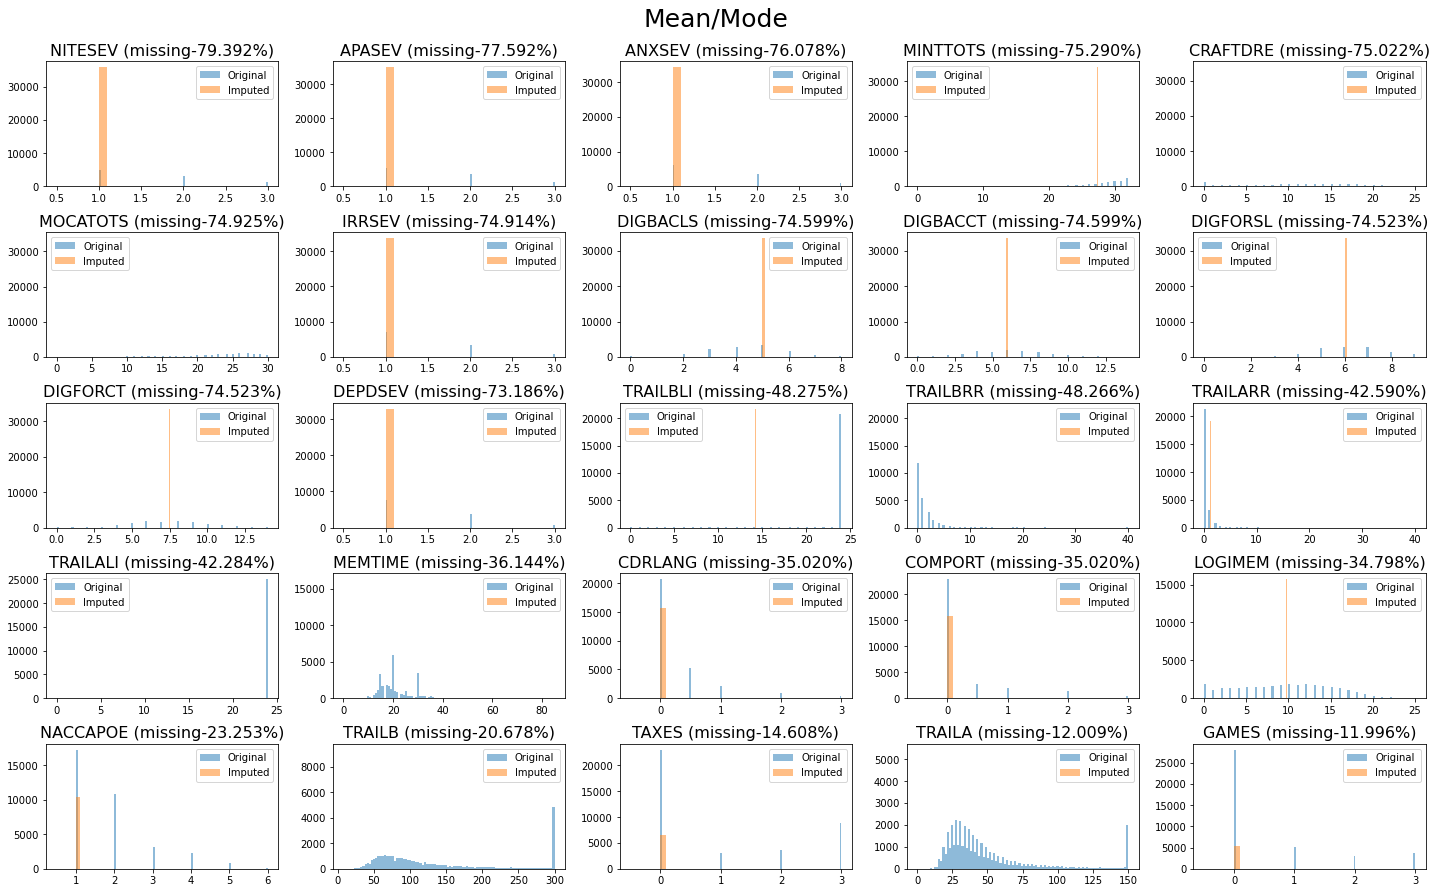

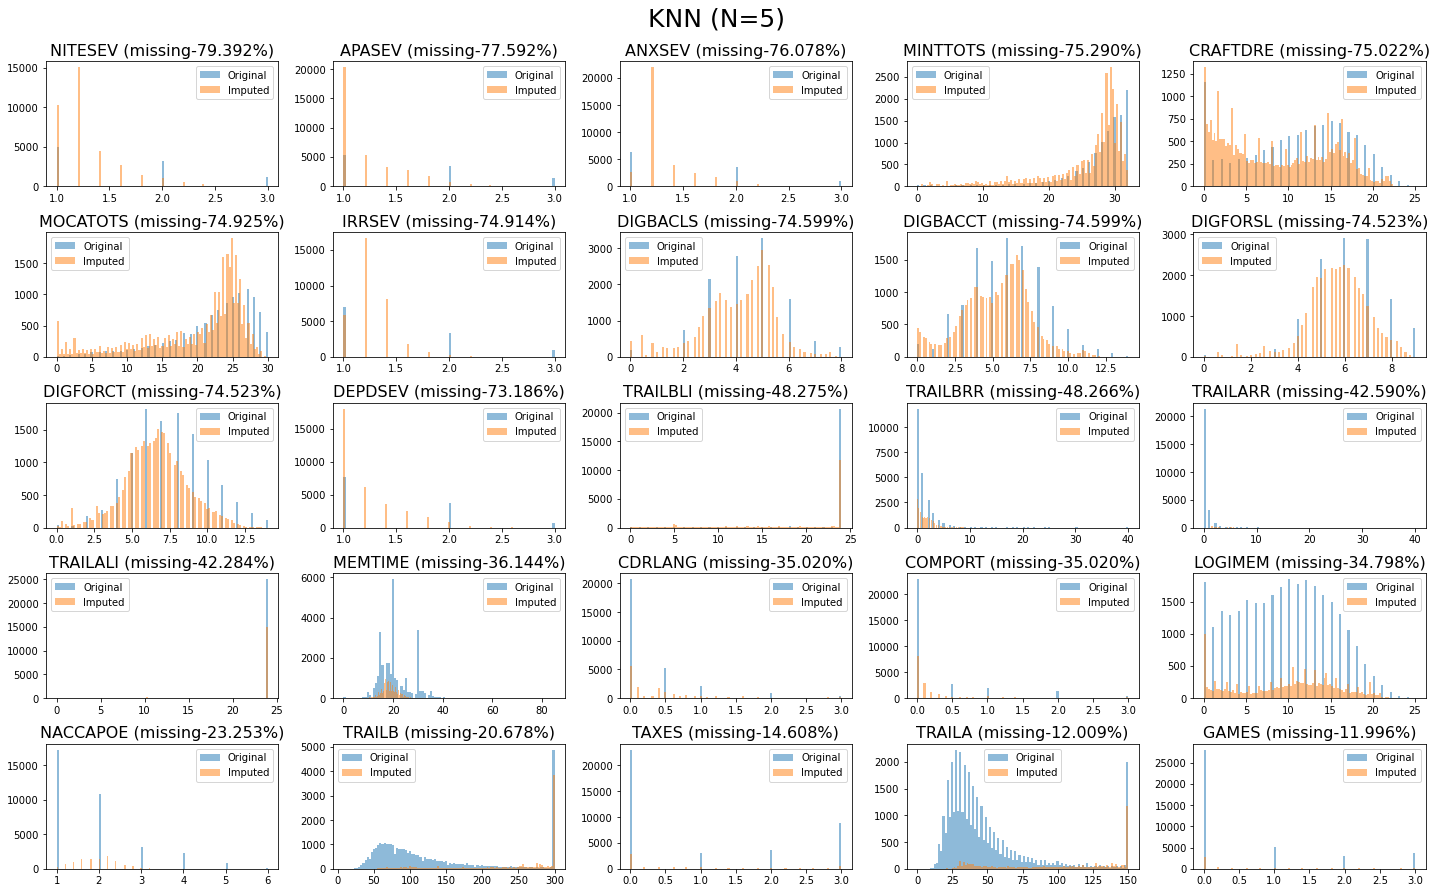

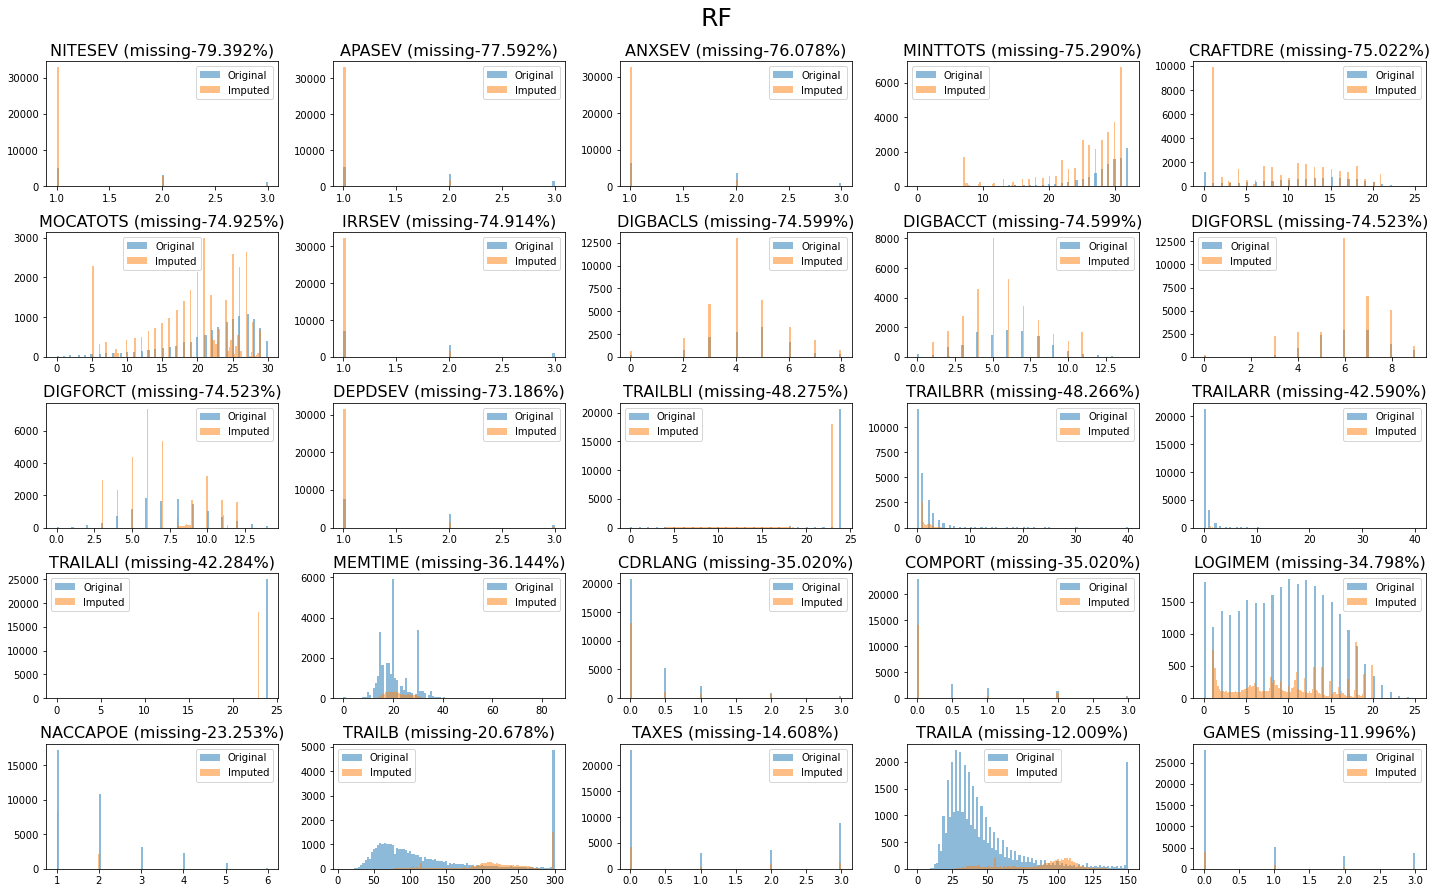

In [17]:
examine_missing_imputation(uds_to_fill, uds_mm, 25, 5, 5, (20, 12), bins=10, suptitle='Mean/Mode')
examine_missing_imputation(uds_to_fill, uds_KNN, 25, 5, 5, (20, 12), bins=100, suptitle='KNN (N=5)')
examine_missing_imputation(uds_to_fill, uds_rf, 25, 5, 5, (20, 12), bins=100, suptitle='RF')

# MRI

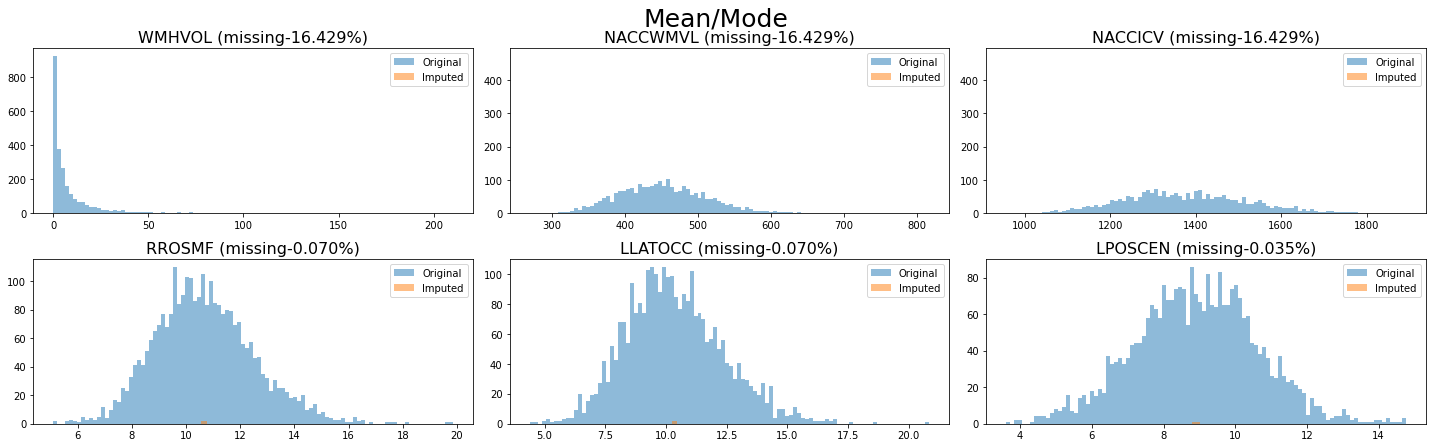

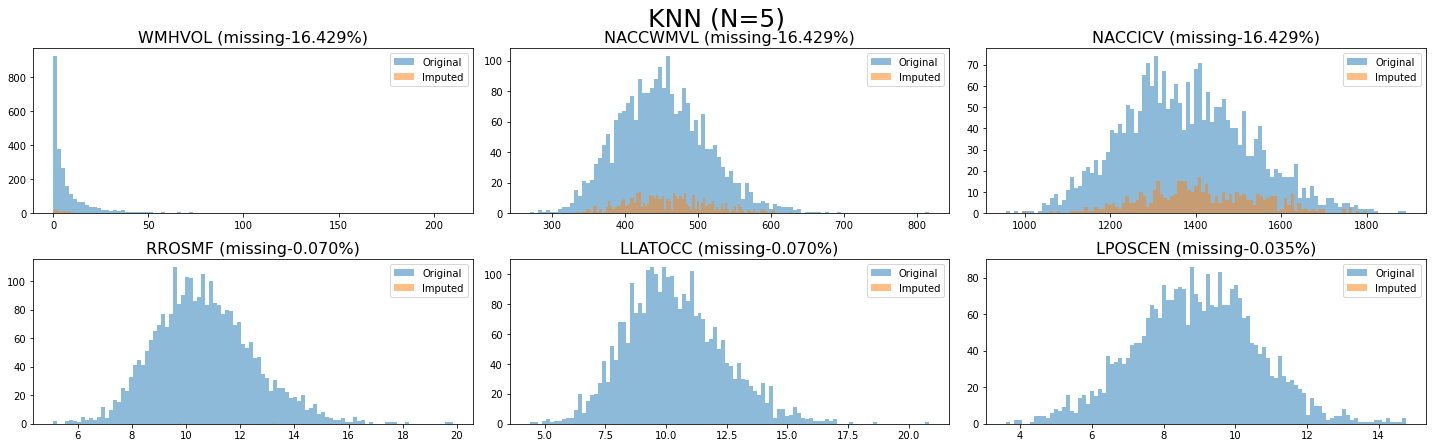

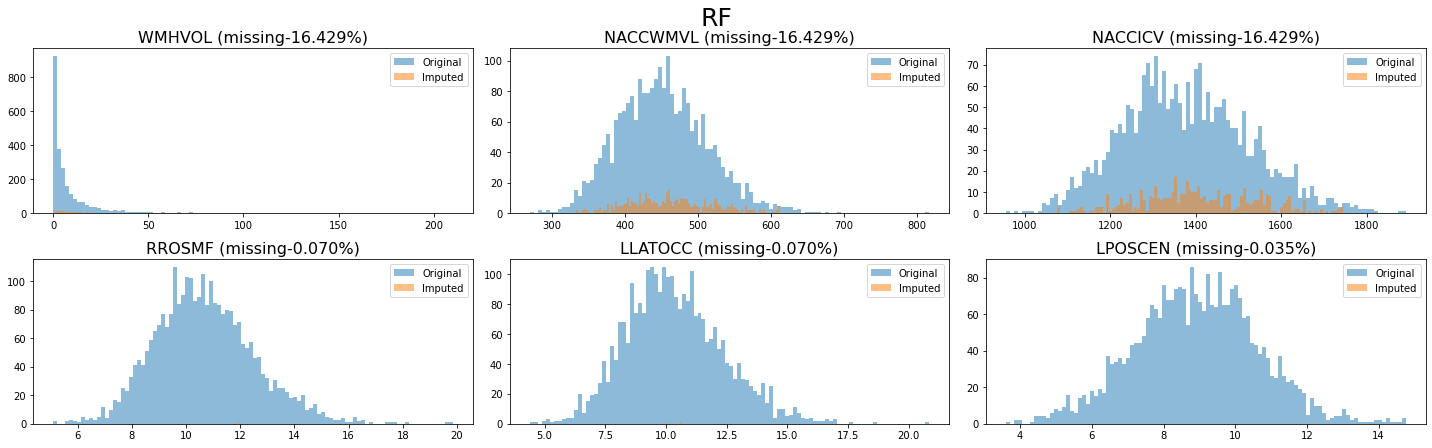

In [18]:
examine_missing_imputation(mri_to_fill, mri_mm, 6, 2, 3, (20, 6), bins=5, suptitle='Mean/Mode')
examine_missing_imputation(mri_to_fill, mri_KNN, 6, 2, 3, (20, 6), bins=100, suptitle='KNN (N=5)')
examine_missing_imputation(mri_to_fill, mri_rf, 6, 2, 3, (20, 6), bins=100, suptitle='RF')

# CSF

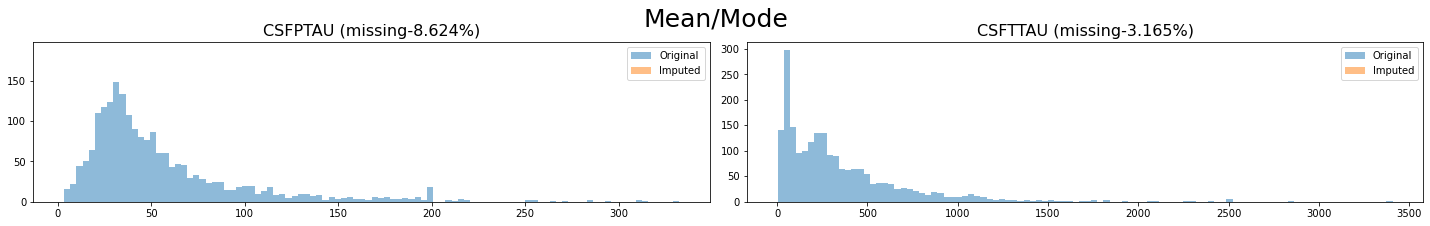

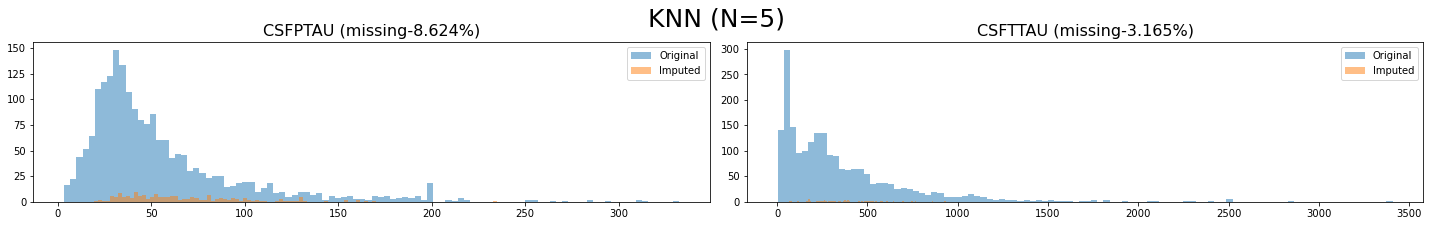

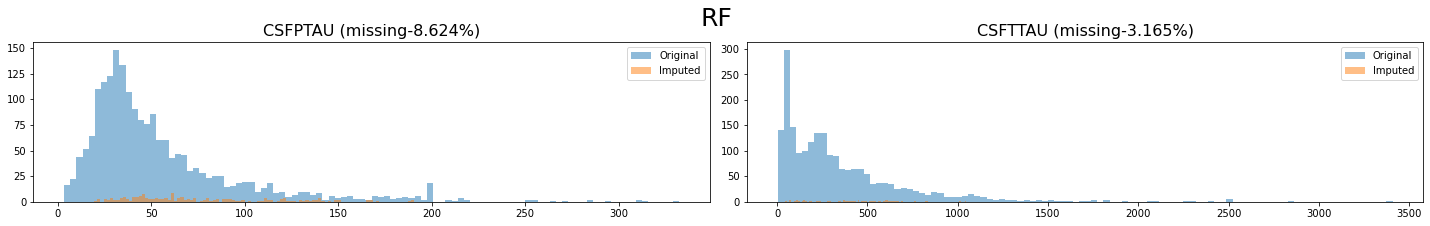

In [22]:
examine_missing_imputation(csf_to_fill, csf_mm, 2, 1, 2, (20, 3), bins=5, suptitle='Mean/Mode')
examine_missing_imputation(csf_to_fill, csf_KNN, 2, 1, 2, (20, 3), bins=100, suptitle='KNN (N=5)')
examine_missing_imputation(csf_to_fill, csf_rf, 2, 1, 2, (20, 3), bins=100, suptitle='RF')